## **Bikes Exploratory Data Analysis**

In this step we are going to go through various visualization techniques in the hope of finding insights on the bike ridership dynamics in the city of New York. Some of the things we are going to explore are:

* Who are the bike users, their age, sex and subscription type, and in what hours do they use the service?
* Duration of rides by days of the week, start hour, gender and subscription type.
* Bikes are paid on trip duration, so what insights and patterns we might get on that?

In [1]:
# load required packages
import pandas as pd
import numpy as np
import plotnine.options as ggplot_options

# visualization libraries and helper utilities
from plotnine import (ggplot, aes, geom_bar, xlab, ylab, theme_minimal, ggtitle,
                      geom_boxplot, facet_wrap, scale_fill_manual, coord_flip)
from utilities.plot_utilities import plot_average_rides_count_per_week
from os.path import abspath

ggplot_options.figure_size = (6, 3)

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


#### **Loading our data**

In [2]:
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
MAX_AGE = 90
# load our dataset

bikes_df = pd.read_csv(abspath("../data/processed/bikes_2016_02.csv"))

# cast to correct types
bikes_df['starttime'] = pd.to_datetime(bikes_df['starttime'])
bikes_df['stoptime'] = pd.to_datetime(bikes_df['stoptime'])

# attach a start day name column
bikes_df['day_name'] = pd.Categorical(bikes_df['starttime'].dt.day_name(), categories=DAY_NAMES)

# attach whether its weekday or weekend
bikes_df['day_type'] = np.where(bikes_df['starttime'].dt.weekday < 5, 'Weekday', 'Weekend').astype(pd.Categorical)

## **Who are our users**?

As a first step, it might be good answering the question who our users are.  What are the different types of customers? Of what gender and age they are? How long do they ride and how many rides do we have according to different hours and days of the week.

In [3]:
(bikes_df['usertype'].value_counts(normalize=True)
 .reset_index()
 .rename(columns={'index': 'usertype', 'usertype': 'percentage'}))

,usertype,percentage
0,Subscriber,0.946799
1,Customer,0.053201


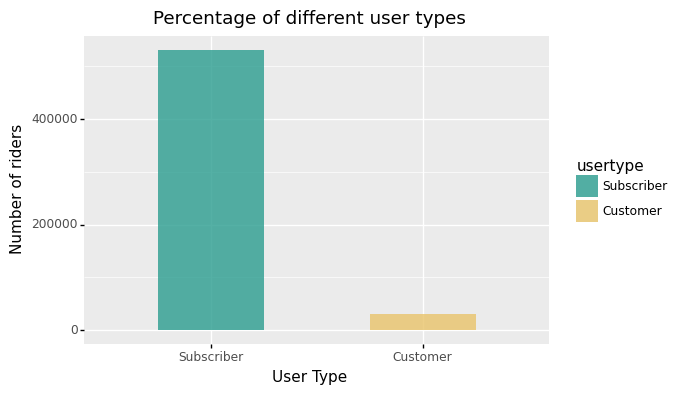

<ggplot: (321447524)>

In [4]:

ggplot_options.figure_size = (6, 4)

usertype_list = bikes_df['usertype'].value_counts().index.tolist()
usertype_cat = pd.Categorical(bikes_df['usertype'], categories=usertype_list)

bikes_df = bikes_df.assign(usertype = usertype_cat)

(ggplot(bikes_df) +
    aes(x='usertype', fill='usertype') +
    geom_bar(stat='count', alpha=0.8, width=0.5) +
    xlab("User Type") +
    ylab("Number of riders") +
    ggtitle("Percentage of different user types") +
    scale_fill_manual(values=["#2a9d8f", "#e9c46a"])
)

From the chart above, we see that most of the bikers are annual subscribers (95%), while only 5% of the users are customers.

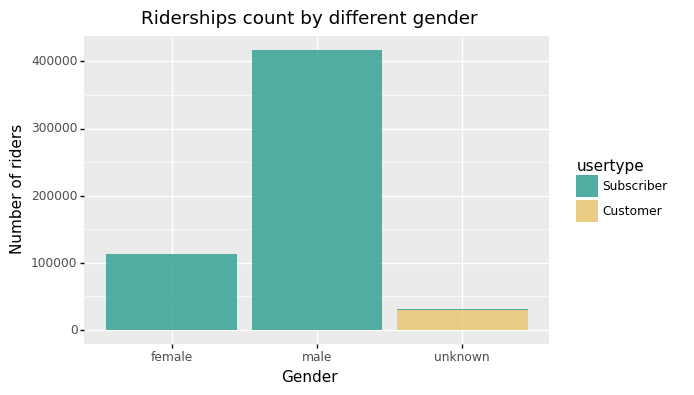

<ggplot: (319343713)>

In [5]:
ggplot_options.figure_size = (6, 4)

(ggplot(bikes_df) +
    aes(x='gender', fill='usertype') +
    geom_bar(stat='count', alpha=0.8) +
    xlab("Gender") +
    ylab("Number of riders") +
    ggtitle("Riderships count by different gender") +
    scale_fill_manual(values=["#2a9d8f", "#e9c46a"])
)

We can see that most of the riders are male, and the ones of unknown gender are mostly customers. As we saw in the Initial Data Analysis, the latter might be due to gender data not being collected for customers.

### **What about the age of our bikers?**

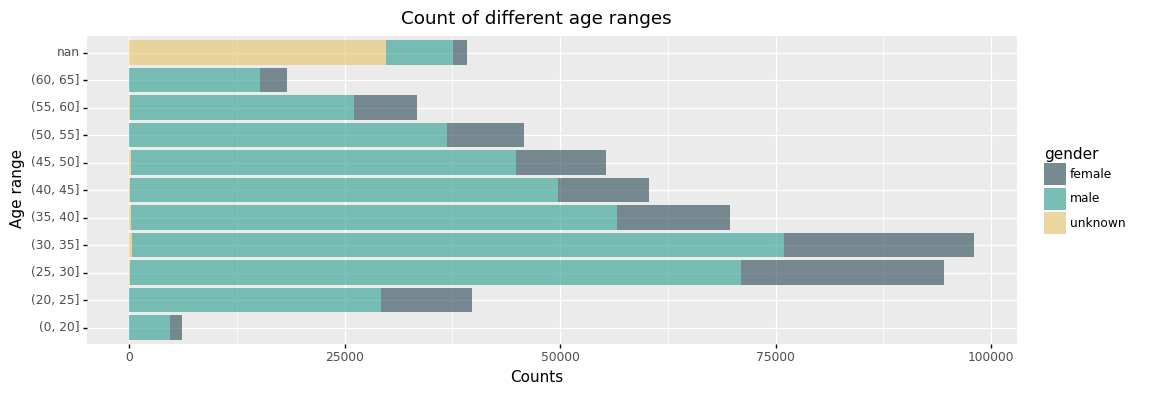

<ggplot: (321626543)>

In [6]:
ggplot_options.figure_size = (12, 4)

AGE_BINS = np.insert(np.arange(start=20, stop=70, step=5), 0, 0, axis=0)

(bikes_df
 .assign(age_range = pd.cut(bikes_df['age'], bins=AGE_BINS).astype(str))
 .pipe(ggplot) +
    aes(x='age_range', fill='gender') +
    geom_bar(stat='count', alpha=0.6) +
    coord_flip() +
    xlab('Age range') +
    ylab('Counts') +
    ggtitle("Count of different age ranges") +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

The most frequent users of the service are of age between 25 and 35.

### **In what time of the day is the service being used most frequently?**

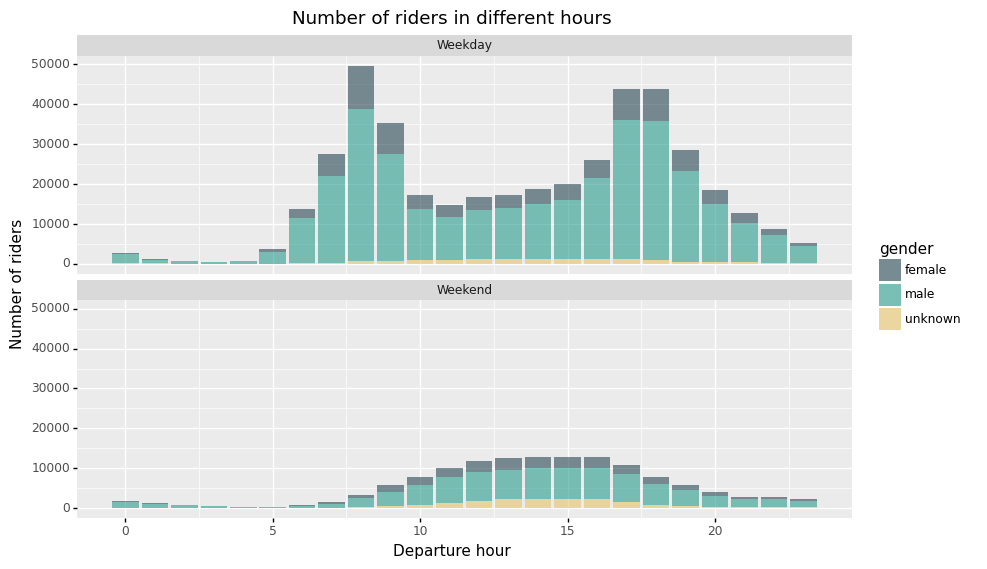

<ggplot: (321683679)>

In [7]:
ggplot_options.figure_size = (10, 6)

(ggplot(bikes_df) +
    aes(x='start_hour', fill='gender') +
    geom_bar(stat='count', alpha=0.6) +
    xlab('Departure hour') +
    ylab("Number of riders") +
    ggtitle("Number of riders in different hours") +
    facet_wrap('day_type', nrow=2) +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

The most active hours in the workweek are from 7 till 10 and after that between 17 and 18 o'clock (when people go to and come back from work).

In our Initial Data Analysis we assumed that all users with unknown gender are of type <u>customer</u>, thus it seems logical that they don't use the service in rush hours, while as visible on the chart above, subscribers use the service mostly in rush hours throughout the weekdays.

The customers are more active in the middle of the day, which is a pattern usually demonstrated by tourists. <br />
In the weekend we can see that subscribers are acting the way customers are, they are biking more in the middle of the day, than in the rush hours.

### **Median Trip duration for each day**

Lets look at how long are users riding a bike for different days of the week. We are going to use the median as an aggregation statistic, since as we saw in the Initial Data Anlysis, more than 99% of the rides last less than an hour.

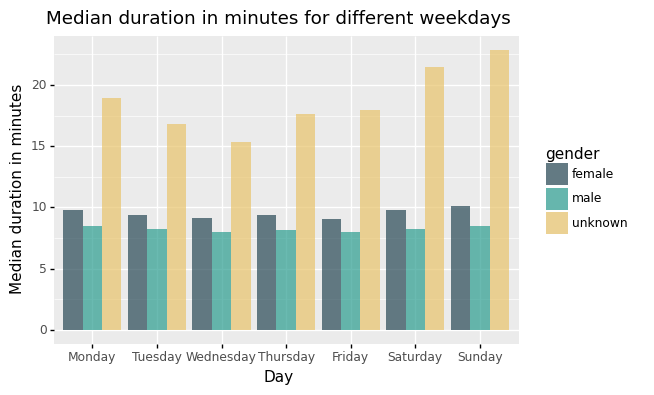

<ggplot: (321707159)>

In [8]:
ggplot_options.figure_size = (6, 4)

(bikes_df
 .groupby(['day_name', 'gender'])
 .median()
 .rename_axis(['weekday', 'gender'], axis='index')
 .reset_index()
 .pipe(ggplot) +
    aes(x='weekday', y='tripduration_minutes', fill='gender') +
    geom_bar(stat='identity', position='dodge', alpha=0.7) +
    xlab('Day') +
    ylab("Median duration in minutes") +
    ggtitle("Median duration in minutes for different weekdays") +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

We can see that the distribution of subscribers trip duration is approximately uniform throughout the week, while customers' trip duration is not only longer during the weekends, but is also longer in general than subscribers' one. This seems to be logical since customers might be tourists that are not using bikes as a mean of transportation from and to work, thus not in a hurry.

Naturally, we are left with asking how many riders we have for each day of the week.

### **Average number of riders for each day**

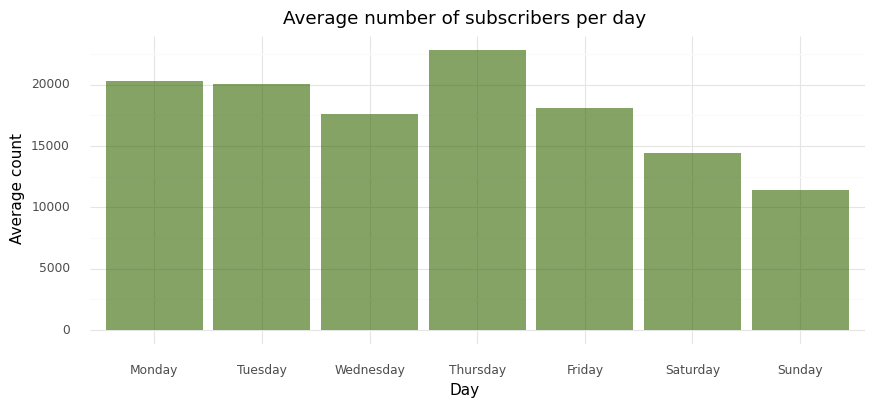

<ggplot: (321947067)>

In [12]:
ggplot_options.figure_size = (10, 4)
(plot_average_rides_count_per_week(bikes_df, 'Subscriber') +
    ggtitle("Average number of subscribers per day") +
    theme_minimal()
)

We see that we have less subscribers during the weekend, when most people don't have to go to work.

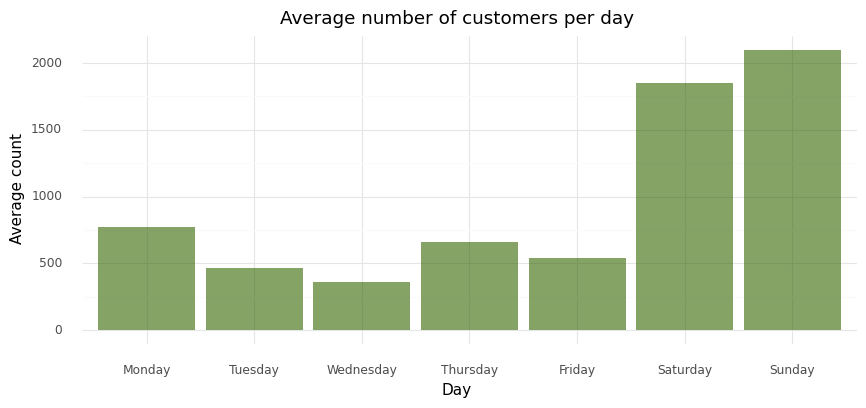

<ggplot: (321944748)>

In [13]:
(plot_average_rides_count_per_week(bikes_df, 'Customer') +
    ggtitle("Average number of customers per day") +
    theme_minimal()
)

We can see that subscribers are traveling more in the weekdays, while the customers prefer the weekends. This supports the assumption that customers are using the bikes mostly for fun and might be tourists.


### **Another question we might ask is who is riding longer? Men or women?** 

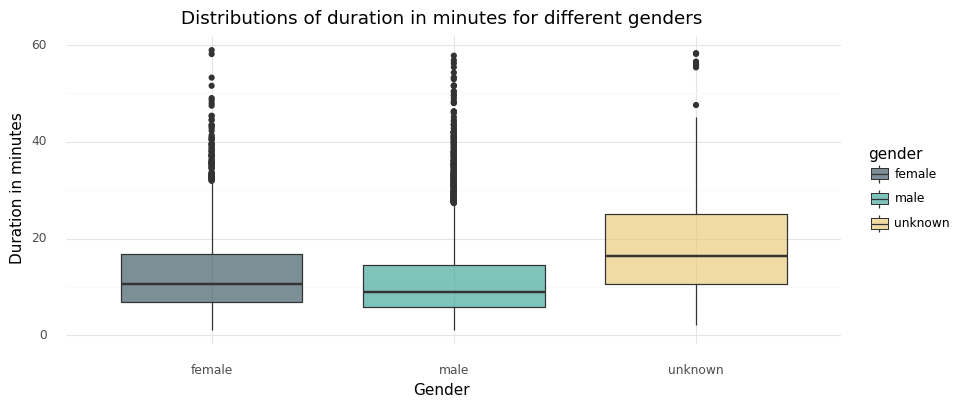

<ggplot: (321450445)>

In [11]:
regular_trips = bikes_df[bikes_df['tripduration_minutes'] < 60]

(ggplot(regular_trips[0:10000]) +
    aes(x='gender', y='tripduration_minutes', fill='gender') +
    geom_boxplot(alpha=0.6) +
    xlab('Gender') +
    ylab("Duration in minutes") +
    ggtitle("Distributions of duration in minutes for different genders") +
    theme_minimal() +
    scale_fill_manual(values=["#264653", "#2a9d8f", "#e9c46a"])
)

We see that women's trip duration is a bit longer than men's one. On the hand, customers' trips continue much longer. This also supports our assumption that customers might be tourists using the service for fun and exploration of the city.